View 1: Monitoring Quality & Measurement Uncertainty Explorer

This view explores how spatial monitoring geometry (station count, azimuthal gap, 
and distance to nearest station) affects earthquake measurement quality.

Analytical Question:
How does monitoring geometry affect measurement uncertainty, and what are the 
implications for data reliability across different networks and regions?

In [2]:
import pandas as pd
import altair as alt
import numpy as np

# Setup
alt.data_transformers.disable_max_rows()
alt.renderers.enable("mimetype")

# Load data
earthquakes = pd.read_csv('../../../data/processed/ordinal_data.csv')

In [3]:
# ----------
# DATA PREPARATION
# ----------
# Create derived fields for analysis
def extract_region(place_str):
    """Extract geographic region from place description"""
    if pd.isna(place_str):
        return 'Unknown'
    place_lower = str(place_str).lower()
    
    if ', ca' in place_lower or 'california' in place_lower:
        return 'California'
    elif 'alaska' in place_lower or ', ak' in place_lower:
        return 'Alaska'
    elif ', wa' in place_lower or 'washington' in place_lower or ', or' in place_lower or 'oregon' in place_lower:
        return 'Pacific NW'
    elif ', nv' in place_lower or 'nevada' in place_lower:
        return 'Nevada'
    elif 'hawaii' in place_lower or ', hi' in place_lower:
        return 'Hawaii'
    elif any(country in place_lower for country in ['mexico', 'canada', 'japan', 'chile', 'indonesia']):
        return 'International'
    else:
        return 'Other US'

earthquakes['region'] = earthquakes['place'].apply(extract_region)

# Station count bins - based on quartile analysis from EDA
earthquakes['nst_bin'] = pd.cut(
    earthquakes['nst'],
    bins=[-np.inf, 5, 10, 20, 50, np.inf],
    labels=['≤5', '6-10', '11-20', '21-50', '>50']
)

# Filter to reasonable ranges based on EDA (remove extreme outliers for clarity)
earthquakes_clean = earthquakes[
    (earthquakes['magError'] <= 0.5) &  # 99th percentile
    (earthquakes['nst'] <= 100)         # 99th percentile
].copy()

print(f"Working with {len(earthquakes_clean):,} events after filtering extreme outliers")
print(f"MagError range: {earthquakes_clean['magError'].min():.3f} - {earthquakes_clean['magError'].max():.3f}")
print(f"Station count range: {earthquakes_clean['nst'].min():.0f} - {earthquakes_clean['nst'].max():.0f}")


Working with 6,148 events after filtering extreme outliers
MagError range: 0.000 - 0.500
Station count range: 0 - 100


In [4]:
# ----------
# INTERACTION DEFINITIONS (ALL DEFINED BEFORE CHARTS)
# ----------

# IMI/UI Widget #1: Radio buttons for review status
status_radio = alt.binding_radio(
    options=['automatic', 'reviewed', None],
    labels=['Automatic Only', 'Reviewed Only', 'All Events'],
    name='Review Status: '
)
status_selection = alt.selection_point(
    fields=['status'],
    bind=status_radio
)

# IMI/UI Widget #2: Slider for minimum station count threshold
station_slider = alt.binding_range(
    min=0,
    max=50,
    step=5,
    name='Min Station Count: '
)
station_param = alt.param(
    name='min_stations',
    value=0,
    bind=station_slider
)

# Advanced DMI #1: Brush selection on heatmap to explore quality conditions
brush = alt.selection_interval(
    name='quality_brush'
)

# Advanced DMI #2: Click selection on bar chart for bi-directional filtering
gap_click = alt.selection_point(
    fields=['gap_level'],
    name='gap_selector'
)

In [5]:
# ----------
# VIZ 1: HEATMAP - Monitoring Quality Grid (Station Count × Gap Level)
# ----------
# Purpose: Explore how station count and geometric coverage jointly affect measurement error
# Low-level tasks: Identify, Compare, Summarize

heatmap = alt.Chart(earthquakes_clean).mark_rect(
    stroke='white',
    strokeWidth=0.5
).encode(
    x=alt.X(
        'nst_bin:O',
        title='Station Count',
        sort=['≤5', '6-10', '11-20', '21-50', '>50'],
        axis=alt.Axis(labelAngle=0, labelFontSize=11)
    ),
    y=alt.Y(
        'gap_level:O',
        title='Azimuthal Gap Level (Geometric Coverage)',
        sort=['high', 'moderate-high', 'moderate-low', 'poor'],
        axis=alt.Axis(labelFontSize=11)
    ),
    color=alt.condition(
        brush,
        alt.Color(
            'mean(magError):Q',
            title='Avg Magnitude Error',
            scale=alt.Scale(scheme='yelloworangered', domain=[0.10, 0.30]),
            legend=alt.Legend(orient='top', titleFontSize=12, labelFontSize=11)
        ),
        alt.value('lightgray')
    ),
    tooltip=[
        alt.Tooltip('nst_bin:O', title='Station Count'),
        alt.Tooltip('gap_level:O', title='Gap Level'),
        alt.Tooltip('mean(magError):Q', title='Avg Mag Error', format='.3f'),
        alt.Tooltip('mean(depthError):Q', title='Avg Depth Error', format='.2f'),
        alt.Tooltip('mean(rms):Q', title='Avg RMS', format='.3f'),
        alt.Tooltip('count():Q', title='# Events', format=',')
    ]
).transform_filter(
    status_selection
).transform_filter(
    alt.datum.nst >= station_param
).add_params(
    brush,
    status_selection,
    station_param
).properties(
    width=380,
    height=280,
    title={
        "text": "Monitoring Quality Grid: Brush Cells to Filter",
        "fontSize": 14,
        "fontWeight": "bold",
        "subtitle": "Darker colors = higher magnitude error. Brush to explore specific quality conditions.",
        "subtitleFontSize": 11
    }
)


In [6]:
# ----------
# VIZ 2: SCATTER PLOT - Station Count vs Magnitude Error
# ----------
# Purpose: Examine relationship between monitoring density and measurement precision
# Low-level tasks: Correlate, Identify outliers, Compare across gap levels

scatter = alt.Chart(earthquakes_clean).mark_circle(
    size=40,
    opacity=0.6,
    stroke='white',
    strokeWidth=0.5
).encode(
    x=alt.X(
        'nst:Q',
        title='Number of Stations Recording Event',
        scale=alt.Scale(domain=[0, 100], nice=True),
        axis=alt.Axis(grid=True, tickCount=5)
    ),
    y=alt.Y(
        'magError:Q',
        title='Magnitude Error',
        scale=alt.Scale(domain=[0, 0.50], nice=True),
        axis=alt.Axis(grid=True, tickCount=5, format='.2f')
    ),
    color=alt.condition(
        gap_click,
        alt.Color(
            'gap_level:N',
            title='Gap Quality',
            sort=['high', 'moderate-high', 'moderate-low', 'poor'],
            scale=alt.Scale(
                domain=['high', 'moderate-high', 'moderate-low', 'poor'],
                range=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
            ),
            legend=alt.Legend(orient='bottom', titleFontSize=12, labelFontSize=11)
        ),
        alt.value('lightgray')
    ),
    tooltip=[
        alt.Tooltip('nst:Q', title='Stations', format=',d'),
        alt.Tooltip('gap:Q', title='Gap (°)', format='.1f'),
        alt.Tooltip('gap_level:N', title='Gap Level'),
        alt.Tooltip('magError:Q', title='Mag Error', format='.3f'),
        alt.Tooltip('status:N', title='Status'),
        alt.Tooltip('mag:Q', title='Magnitude', format='.2f')
    ]
).transform_filter(
    brush
).transform_filter(
    status_selection
).transform_filter(
    alt.datum.nst >= station_param
).transform_filter(
    gap_click
).properties(
    width=380,
    height=280,
    title={
        "text": "Station Density vs Measurement Error",
        "fontSize": 14,
        "fontWeight": "bold",
        "subtitle": "Filtered by quality grid selection & gap level click. Trend shows error decreases with more stations.",
        "subtitleFontSize": 11
    }
)

# Add polynomial trend line (degree 2)
trend = scatter.transform_regression(
    'nst', 'magError',
    method='poly',
    order=2,
    extent=[0, 100]
).mark_line(
    color='darkred',
    strokeDash=[5, 5],
    size=2.5,
    opacity=0.8
)

scatter_with_trend = scatter + trend


In [7]:
# ----------
# VIZ 3: BAR CHART - Gap Level Distribution
# ----------
# Purpose: Show composition of selected events by geometric coverage quality
# Low-level tasks: Compare, Distribute, Filter
# Bi-directional: Click bars to filter scatter plot

bars = alt.Chart(earthquakes_clean).mark_bar(
    stroke='white',
    strokeWidth=1
).encode(
    x=alt.X(
        'count():Q',
        title='Number of Events',
        axis=alt.Axis(grid=True, format=',d')
    ),
    y=alt.Y(
        'gap_level:N',
        title='Gap Level',
        sort=['high', 'moderate-high', 'moderate-low', 'poor'],
        axis=alt.Axis(labelFontSize=11)
    ),
    color=alt.Color(
        'gap_level:N',
        scale=alt.Scale(
            domain=['high', 'moderate-high', 'moderate-low', 'poor'],
            range=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
        ),
        legend=None
    ),
    opacity=alt.condition(
        gap_click,
        alt.value(1.0),
        alt.value(0.3)
    ),
    tooltip=[
        alt.Tooltip('gap_level:N', title='Gap Level'),
        alt.Tooltip('count():Q', title='Event Count', format=',d'),
        alt.Tooltip('mean(magError):Q', title='Avg Error', format='.3f')
    ]
).transform_filter(
    brush
).transform_filter(
    status_selection
).transform_filter(
    alt.datum.nst >= station_param
).add_params(
    gap_click
).properties(
    width=380,
    height=180,
    title={
        "text": "Gap Level Distribution (Click to Filter Scatter)",
        "fontSize": 14,
        "fontWeight": "bold",
        "subtitle": "Click bars to isolate specific gap levels in scatter plot above (bi-directional interaction).",
        "subtitleFontSize": 11
    }
)

In [8]:
# ----------
# VIZ 4: TEXT SUMMARY - Real-time Statistics
# ----------
# Purpose: Provide quantitative summary of filtered selection
# Low-level tasks: Summarize, Retrieve facts

text_summary = alt.Chart(earthquakes_clean).mark_text(
    align='left',
    baseline='top',
    fontSize=12,
    dx=10,
    dy=10,
    lineBreak='\n'
).encode(
    text=alt.Text('summary:N')
).transform_filter(
    brush
).transform_filter(
    status_selection
).transform_filter(
    alt.datum.nst >= station_param
).transform_filter(
    gap_click
).transform_aggregate(
    count='count()',
    avg_mag_error='mean(magError)',
    median_mag_error='median(magError)',
    avg_depth_error='mean(depthError)',
    avg_rms='mean(rms)',
    avg_nst='mean(nst)',
    avg_gap='mean(gap)'
).transform_calculate(
    summary=(
        '"SELECTION STATISTICS" + "\\n" + '
        '"━━━━━━━━━━━━━━━━━━━━" + "\\n" + '
        '"Events Selected: " + format(datum.count, ",") + "\\n\\n" + '
        '"MONITORING QUALITY" + "\\n" + '
        '"  Avg Stations: " + format(datum.avg_nst, ".1f") + "\\n" + '
        '"  Avg Gap: " + format(datum.avg_gap, ".1f") + "°" + "\\n\\n" + '
        '"MEASUREMENT ERRORS" + "\\n" + '
        '"  Mean Mag Error: " + format(datum.avg_mag_error, ".3f") + "\\n" + '
        '"  Median Mag Error: " + format(datum.median_mag_error, ".3f") + "\\n" + '
        '"  Avg Depth Error: " + format(datum.avg_depth_error, ".2f") + " km" + "\\n" + '
        '"  Avg RMS: " + format(datum.avg_rms, ".3f")'
    )
).properties(
    width=380,
    height=180,
    title={
        "text": "Selection Summary Statistics",
        "fontSize": 14,
        "fontWeight": "bold",
        "subtitle": "Updates in real-time based on all active filters.",
        "subtitleFontSize": 11
    }
)

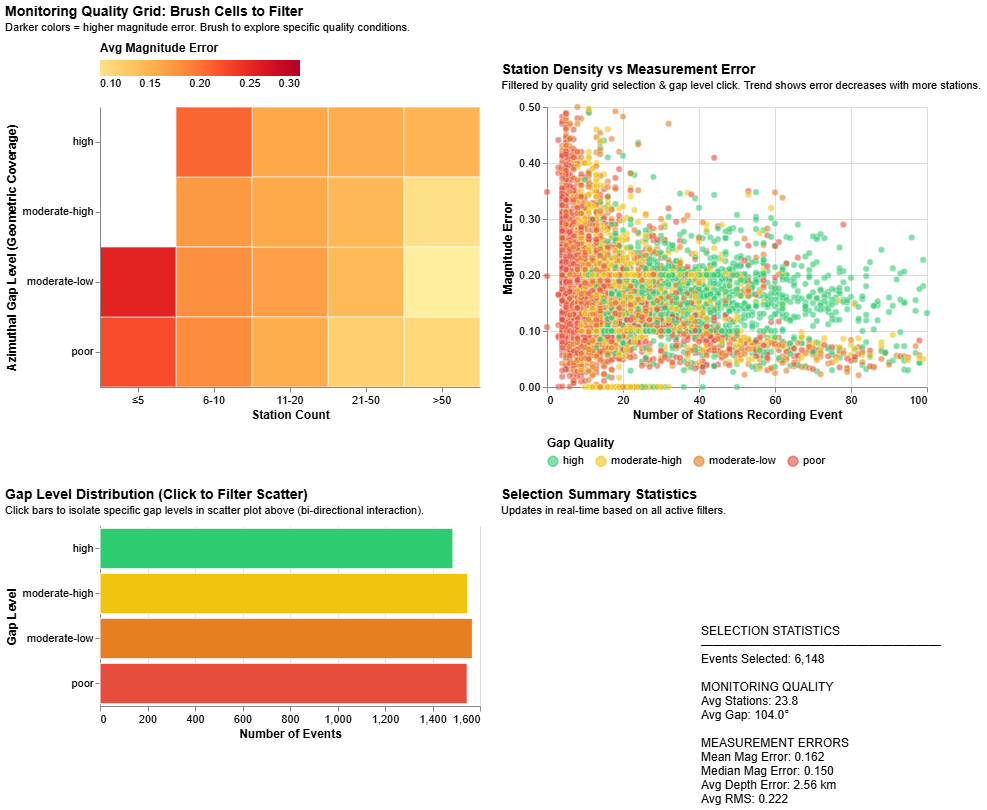

In [9]:
# ----------
# FINAL LAYOUT
# ----------
# Optimized for screen space: 2x2 grid layout
# Top row: Quality grid (input) | Scatter (output showing correlation)
# Bottom row: Bar chart (bi-directional) | Text summary (quantitative overview)

top_row = heatmap | scatter_with_trend
bottom_row = bars | text_summary

view1 = (top_row & bottom_row).configure_view(
    strokeWidth=0
).configure_axis(
    labelFontSize=11,
    titleFontSize=12
).configure_legend(
    titleFontSize=12,
    labelFontSize=11
).configure_title(
    fontSize=14,
    anchor='start',
    offset=10
)

view1